In [1]:
import math
import time

import cv2
import matplotlib.pyplot as plt
import numpy as np

from utils import cropping_center

In [2]:
class PatchExtractor(object):
    """
    Extractor to generate patches with or without padding.
    Turn on debug mode to see how it is done.

    Args:
        x         : input image, should be of shape HWC
        win_size  : a tuple of (h, w)
        step_size : a tuple of (h, w)
        debug     : flag to see how it is done
    Return:
        a list of sub patches, each patch has dtype same as x

    Examples:
        >>> xtractor = PatchExtractor((450, 450), (120, 120))
        >>> img = np.full([1200, 1200, 3], 255, np.uint8)
        >>> patches = xtractor.extract(img, 'mirror')
    """
    def __init__(self, win_size, step_size, debug=False):

        self.patch_type = 'mirror'
        self.win_size  = win_size
        self.step_size = step_size
        self.debug   = debug
        self.counter = 0

    def __get_patch(self, x, ptx):
        pty = (ptx[0]+self.win_size[0],
               ptx[1]+self.win_size[1])
        win = x[ptx[0]:pty[0], 
                ptx[1]:pty[1]]
        assert win.shape[0] == self.win_size[0] and \
               win.shape[1] == self.win_size[1],    \
               '[BUG] Incorrect Patch Size {0}'.format(win.shape)
        if self.debug:
            if self.patch_type == 'mirror':
                cen = cropping_center(win, self.step_size)
                cen = cen[...,self.counter % 3]
                cen.fill(150)
            cv2.rectangle(x,ptx,pty,(255,0,0),2)  
            plt.imshow(x)
            plt.show(block=False)
            plt.pause(1)
            plt.close()
            self.counter += 1
        return win
    
    def __extract_valid(self, x):
        """
        Extracted patches without padding, only work in case win_size > step_size
        
        Note: to deal with the remaining portions which are at the boundary a.k.a
        those which do not fit when slide left->right, top->bottom), we flip 
        the sliding direction then extract 1 patch starting from right / bottom edge. 
        There will be 1 additional patch extracted at the bottom-right corner

        Args:
            x         : input image, should be of shape HWC
            win_size  : a tuple of (h, w)
            step_size : a tuple of (h, w)
        Return:
            a list of sub patches, each patch is same dtype as x
        """

        im_h = x.shape[0] 
        im_w = x.shape[1]

        def extract_infos(length, win_size, step_size):
            flag = (length - win_size) % step_size != 0
            last_step = math.floor((length - win_size) / step_size)
            last_step = (last_step + 1) * step_size
            return flag, last_step

        h_flag, h_last = extract_infos(im_h, self.win_size[0], self.step_size[0])
        w_flag, w_last = extract_infos(im_w, self.win_size[1], self.step_size[1])    

        sub_patches = []
        #### Deal with valid block
        for row in range(0, h_last, self.step_size[0]):
            for col in range(0, w_last, self.step_size[1]):
                win = self.__get_patch(x, (row, col))
                sub_patches.append(win)  
        #### Deal with edge case
        if h_flag:
            row = im_h - self.win_size[0]
            for col in range(0, w_last, self.step_size[1]):
                win = self.__get_patch(x, (row, col))
                sub_patches.append(win)  
        if w_flag:
            col = im_w - self.win_size[1]
            for row in range(0, h_last, self.step_size[0]):
                win = self.__get_patch(x, (row, col))
                sub_patches.append(win)  
        if h_flag and w_flag:
            ptx = (im_h - self.win_size[0], im_w - self.win_size[1])
            win = self.__get_patch(x, ptx)
            sub_patches.append(win)  
        return sub_patches
    
    def __extract_mirror(self, x):
        """
        Extracted patches with mirror padding the boundary such that the 
        central region of each patch is always within the orginal (non-padded)
        image while all patches' central region cover the whole orginal image

        Args:
            x         : input image, should be of shape HWC
            win_size  : a tuple of (h, w)
            step_size : a tuple of (h, w)
        Return:
            a list of sub patches, each patch is same dtype as x
        """

        diff_h = self.win_size[0] - self.step_size[0]
        padt = diff_h // 2
        padb = diff_h - padt

        diff_w = self.win_size[1] - self.step_size[1]
        padl = diff_w // 2
        padr = diff_w - padl

        pad_type = 'constant' if self.debug else 'reflect'
        x = np.lib.pad(x, ((padt, padb), (padl, padr), (0, 0)), pad_type)
        sub_patches = self.__extract_valid(x)
        return sub_patches

    def extract(self, x, patch_type):
        patch_type = patch_type.lower()
        self.patch_type = patch_type
        if patch_type == 'valid':
            return self.__extract_valid(x)
        elif patch_type == 'mirror':
            return self.__extract_mirror(x)
        else:
            assert False, 'Unknown Patch Type [%s]' % patch_type
        return

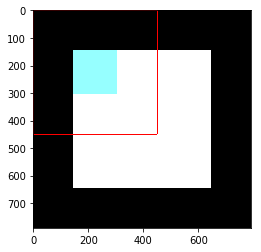

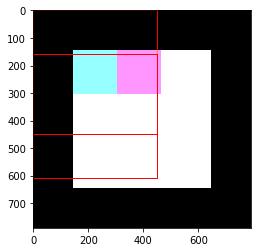

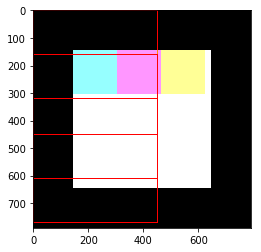

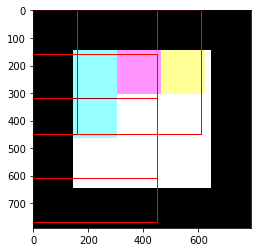

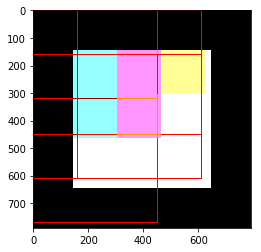

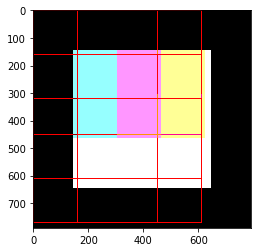

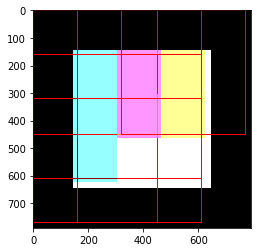

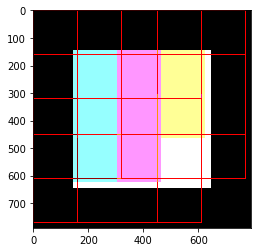

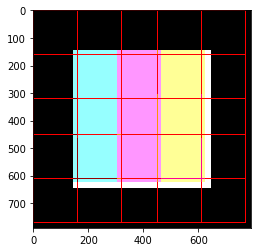

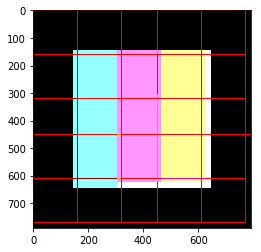

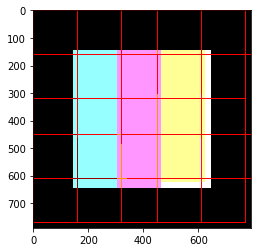

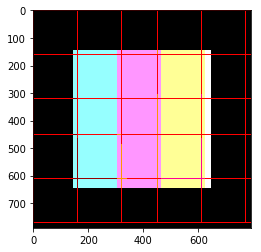

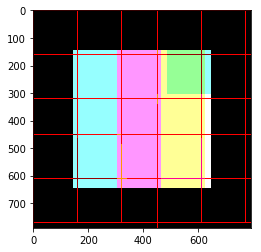

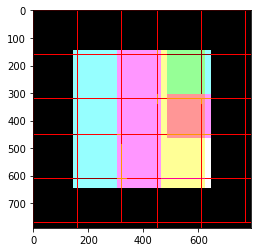

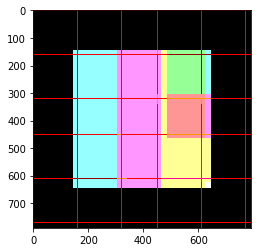

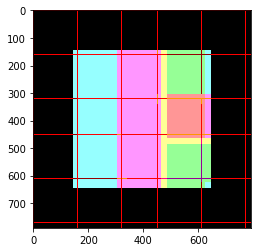

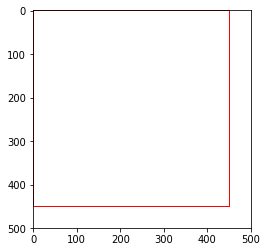

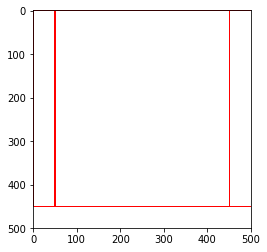

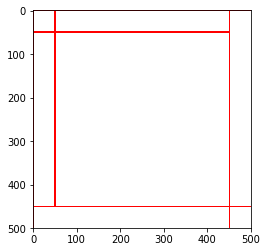

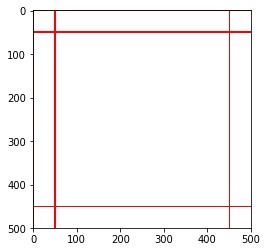

[array([[[255,   0,   0],
         [255,   0,   0],
         [255,   0,   0],
         ...,
         [255,   0,   0],
         [255,   0,   0],
         [255,   0,   0]],
 
        [[255,   0,   0],
         [255,   0,   0],
         [255,   0,   0],
         ...,
         [255,   0,   0],
         [255,   0,   0],
         [255,   0,   0]],
 
        [[255,   0,   0],
         [255,   0,   0],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255,   0,   0]],
 
        ...,
 
        [[255,   0,   0],
         [255,   0,   0],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255,   0,   0]],
 
        [[255,   0,   0],
         [255,   0,   0],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255,   0,   0]],
 
        [[255,   0,   0],
         [255,   0,   0],
         [255,   0,   0],
         ...,
         [255,   0,   0],
  

In [3]:
# toy example for debug
# 355x355, 480x480
xtractor = PatchExtractor((450, 450), (160, 160), debug=True)
a = np.full([500, 500, 3], 255, np.uint8)
xtractor.extract(a, 'mirror')
xtractor.extract(a, 'valid')